In [1]:
%%capture
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

In [2]:
import os
os.makedirs('/content/raw', exist_ok = True)
if not os.path.exists('/content/Project_data'):
    !wget -qq 'https://drive.usercontent.google.com/download?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&authuser=0&confirm=t&uuid=faf8eb67-a465-4b76-80b1-5b88a80636ac&at=APZUnTXrM6uktCZvJt_HJpJYg4M0%3A1705871212413' -O /content/raw/data.zip
    !unzip -qq /content/raw/data.zip

In [3]:
os.chdir('/content/drive/MyDrive/Gesture Recognition TF/src')

## Helper

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('icefire')

import numpy as np
from configs.config import Config
from models.cnn_3d import conv3D, conv3Dxnorm, trial
from train.main import Trainer

def plot_performance(path):
    log_df = pd.read_csv(os.path.join(path, 'training.log'), sep = ',')
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    sns.lineplot(data = log_df, x = 'epoch', y = 'loss', ax = axes[0], label = 'train_loss')
    sns.lineplot(data = log_df, x = 'epoch', y = 'val_loss', ax = axes[0], label = 'val_loss')
    axes[0].set(xlabel = 'epoch', ylabel = 'loss', title = 'Loss profile')
    sns.lineplot(data = log_df, x = 'epoch', y = 'categorical_accuracy', ax = axes[1], label = 'train_accuracy')
    sns.lineplot(data = log_df, x = 'epoch', y = 'val_categorical_accuracy', ax = axes[1], label = 'val_accuracy')
    axes[1].set(xlabel = 'epoch', ylabel = 'accuracy', title = 'accuracy profile')
    plt.tight_layout()
    plt.show()

## (Baseline) Experiment 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16   3472      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                     

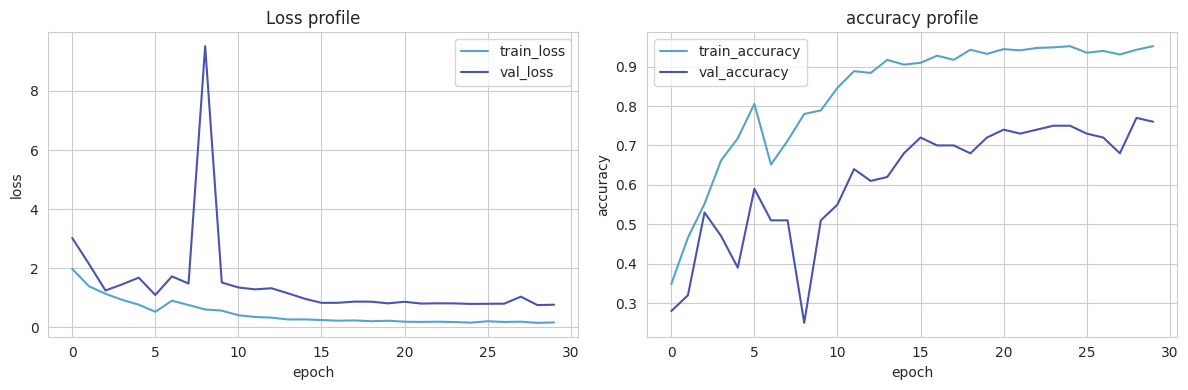

In [ ]:
config = Config()
config.data_dir = '../data'
config.models_dir = '../models'
config.model_name = 'cnn3d_exp1'
config.colab_clips_dir = '/content/Project_data'
config.aug_size = 0
config.clip_dim = (30, 3, 120, 120)
config.train_batch_size = 10
config.valid_batch_size = 64
config.num_epochs = 30
config.frame_idx = list(range(30))
config.save_checkpoint = False
model = conv3D(conv_filters=(8, 16),
               kernel_size = (3, 3),
               dense_nodes=(256,128),
               dropout=0.25,
               clip_dim = config.clip_dim)
print(model.summary())
print("Total Params:", f'{round(model.count_params()/1e6,2)}M'); print('-'*120)
history, meta_data = Trainer(config = config).start(model = model)
plot_performance(path = config.dest_path)

**Observations:** Although the model performed reasonably well, the 221M parameters add space complexity. It also overfitting. In the next experiment, the convolution layers are increased to reduce parameters (because of maxpooling layer)

## Experiment 2
- Changes
  - Convolution layers changed from [8, 16] to [16, 32, 64]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 conv3d_7 (Conv3D)           (None, 30, 120, 120, 32   13856     
                             )                                   
                                                                 
 activation_10 (Activation)  (None, 30, 120, 120, 32   0         
                             )                                   
                                                                 
 batch_normalization_8 (Bat  (None, 30, 120, 120, 32   128       
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 15, 60, 60, 32)   

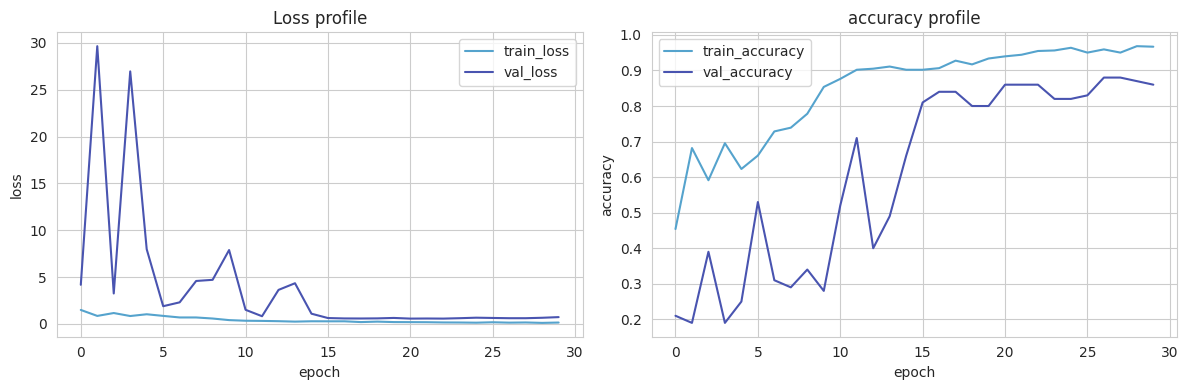

In [ ]:
config = Config()
config.data_dir = '../data'
config.models_dir = '../models'
config.model_name = 'cnn3d_exp2'
config.colab_clips_dir = '/content/Project_data'
config.aug_size = 0
config.clip_dim = (30, 3, 120, 120)
config.train_batch_size = 10
config.valid_batch_size = 64
config.num_epochs = 30
config.frame_idx = list(range(30))
config.save_checkpoint = False
model = conv3D(conv_filters=(16, 32, 64),
               kernel_size = (3, 3, 3),
               dense_nodes=(256,128),
               dropout=0.25,
               clip_dim = config.clip_dim)
print(model.summary())
print("Total Params:", f'{round(model.count_params()/1e6,2)}M'); print('-'*120)
history, meta_data = Trainer(config = config).start(model = model)
plot_performance(path = config.dest_path)

**Observations:** Model performance improved because of better features were extracted with using more filters in the convolution layers.
- Train acc: 0.8800
- Validation acc: 0.9670

## Experiment 6
- Add another convolution layer [16, 32, 64] -> [16, 32, 564, 128]
- Use 50% of randomly sampled train clips to train the models for generalizability.
- Increased epochs from 30 to 40

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 32   13856     
                             )                                   
                                                                 
 activation_13 (Activation)  (None, 30, 120, 120, 32   0         
                             )                                   
                                                                 
 batch_normalization_11 (Ba  (None, 30, 120, 120, 32   128       
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 15, 60, 60, 32)   

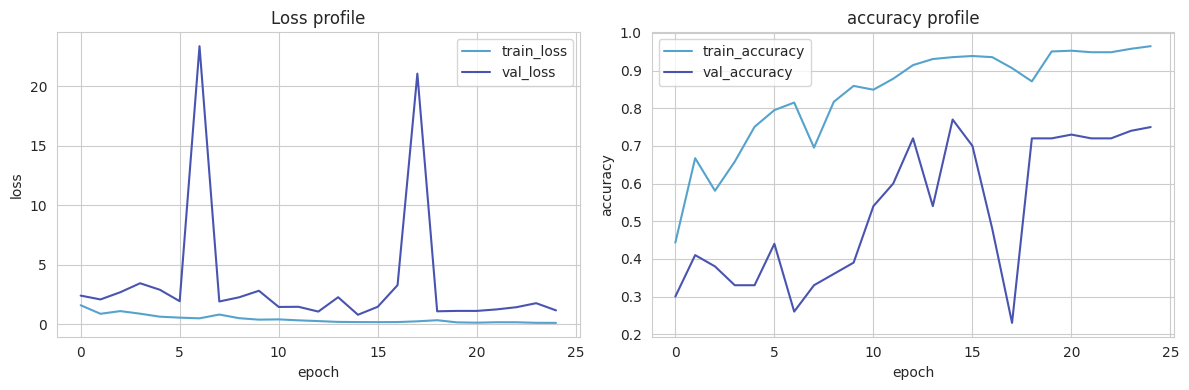

In [7]:
config = Config()
config.data_dir = '../data'
config.models_dir = '../models'
config.model_name = 'cnn3d_exp6'
config.colab_clips_dir = '/content/Project_data'
config.aug_size = 0.5
config.clip_dim = (30, 3, 120, 120)
config.train_batch_size = 10
config.valid_batch_size = 64
config.num_epochs = 40
config.frame_idx = list(range(30))
config.save_checkpoint = True
model = conv3D(conv_filters=(16, 32, 64, 128),
               kernel_size = (3, 3, 3, 3),
               dense_nodes=(256,128),
               dropout=0.25,
               clip_dim = config.clip_dim)
print(model.summary())
print("Total Params:", f'{round(model.count_params()/1e6,2)}M'); print('-'*120)
history, meta_data = Trainer(config = config).start(model = model)
plot_performance(path = config.dest_path)

## Experiment 4

In [ ]:
config = Config()
config.data_dir = '../data'
config.models_dir = '../models'
config.model_name = 'cnn3d_exp4'
config.colab_clips_dir = '/content/Project_data'
config.aug_size = 0.5
config.clip_dim = (20, 3, 120, 120)
config.train_batch_size = 10
config.valid_batch_size = 64
config.num_epochs = 40
config.frame_idx = list(range(5, 25))
config.save_checkpoint = True
model = conv3D(conv_filters=(16, 32, 64, 128),
               kernel_size = (3, 3, 3, 3),
               dense_nodes=(256,128),
               dropout=0.25,
               clip_dim = config.clip_dim)
print(model.summary())
print("Total Params:", f'{round(model.count_params()/1e6,2)}M'); print('-'*120)
history, meta_data = Trainer(config = config).start(model = model)
plot_performance(path = config.dest_path)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 conv3d_14 (Conv3D)          (None, 20, 120, 120, 32   13856     
                             )                                   
                                                                 
 activation_19 (Activation)  (None, 20, 120, 120, 32   0         
                             )                                   
                                                                 
 batch_normalization_16 (Ba  (None, 20, 120, 120, 32   128       
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_10 (MaxPooli  (None, 10, 60, 60, 32)   